# 📘 **Introducción práctica al Proceso de Decisión de Markov (MDP)**

<br>

En este notebook, vamos a poner en práctica los conceptos aprendidos sobre **tareas de control** y **procesos de decisión de Markov** (Markov Decision Processes, MDPs).  

En particular, nos familiarizaremos con una biblioteca de software llamada **OpenAI Gym**, que nos proporciona una interfaz simple para interactuar con este tipo de entornos.

<br><br><br>



In [1]:
# @title Setup code (not important) - Run this cell by pressing "Shift + Enter"



!pip install -qq gym==0.23.0


from typing import Tuple, Dict, Optional, Iterable

import numpy as np
import matplotlib
from matplotlib import animation

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## 📚 **Vista rápida de la biblioteca Gym**

<br>

**Gym** es una biblioteca desarrollada para la investigación en **aprendizaje por refuerzo**. Nos proporciona una interfaz sencilla para una gran variedad de tareas, entre ellas:

- 🎯 **Tareas clásicas de control**: *CartPole, Pendulum, MountainCar, etc.*
- 🎮 **Videojuegos clásicos**: *Space Invaders, Breakout, Pong, etc.*
- ⚙️ **Tareas de control continuo**
- 🤖 **Manipulación con brazos robóticos**

En esta sección nos familiarizaremos con los **cinco métodos clave** que utilizaremos para resolver una tarea de control.

<br><br>

![Diagrama de aprendizaje por refuerzo](https://upload.wikimedia.org/wikipedia/commons/1/1b/Reinforcement_learning_diagram.svg)



## Maze environment: Find the exit.


## 🧠 **Familiarización con el entorno de aprendizaje**

En esta sección, vamos a familiarizarnos con el **entorno** que utilizaremos en las lecciones **2 (programación dinámica)**, **3 (métodos Monte Carlo)** y **4 (métodos de diferencia temporal)**.

Este entorno es perfecto para aprender los conceptos básicos del **aprendizaje por refuerzo (Reinforcement Learning)** porque:

## 🧭 **Características del entorno**

- Tiene pocos estados (**25 en total**).
- Las transiciones entre estados son **deterministas** ($p(s', r \mid s, a) = 1$).
- Todas las recompensas son iguales (**-1**) hasta que el episodio concluye, lo que **facilita el estudio de las funciones de valor y valor-acción**.

<br>

A través de este entorno, vamos a repasar los conceptos vistos en la **Lección 1 (El Proceso de Decisión de Markov)**:

- 📍 Estados y espacio de estados  
- 🎯 Acciones y espacio de acciones  
- 🔄 Trayectorias y episodios  
- 💰 Recompensas y retornos  
- 🧠 Política

<br>

## 🧩 **Descripción del entorno**

El entorno es un **laberinto de 5x5 celdas**, en el que el objetivo del agente es encontrar la salida, ubicada en la esquina inferior derecha, en la celda **(4,4)**.  
En la imagen, la salida está coloreada de **verde claro**.

Para llegar a la salida, el agente puede realizar **cuatro acciones diferentes**:

- 🔼 Moverse hacia **arriba**
- 🔽 Moverse hacia **abajo**
- ◀️ Moverse hacia la **izquierda**
- ▶️ Moverse hacia la **derecha**

<br>

###### Create the environment.

In [2]:
env = Maze()

#####Estados y espacio de estados

Los estados consisten en una tupla de dos enteros, ambos en el rango [0, 4], que representan la fila y la columna en la que el agente se encuentra actualmente:
<br>
<br>

\begin{equation}
    s = (row, column) \;\\
    row, column \in \{0,1,2,3, 4\}
\end{equation}
<br>
<br>
El espacio de estados (conjunto de todos los posibles estados en la tarea) tiene 25 elementos (todas las combinaciones posibles de filas y columnas).:


\begin{equation}
    Rows \times Columns \;\\
    S = \{(0, 0), (0, 1), (1, 0), ...\}
\end{equation}

La información sobre el espacio de estados se almacena en la propiedad env.observation_space. En este entorno, es de tipo MultiDiscrete([5, 5]), lo que significa que consiste en dos elementos (filas y columnas), cada uno con 5 valores diferentes..

In [3]:
print("Estado inicial",env.reset())
print("Espacio de estados",env.observation_space)

Estado inicial (0, 0)
Espacio de estados MultiDiscrete([5 5])


##### Acciones y espacio de acciones

En este entorno, hay cuatro acciones diferentes y están representadas por enteros:

\begin{equation}
a \in \{0, 1, 2, 3\}
\end{equation}

0 -> mover hacia arriba
1 -> mover hacia la derecha
2 -> mover hacia abajo
3 -> mover hacia la izquierda"

Para ejecutar una acción, simplemente pásala como un argumento al método env.step. La información sobre el espacio de acciones se almacena en la propiedad env.action_space, que es de la clase Discrete(4). Esto significa que en este caso solo consiste en un elemento en el rango [0,4), a diferencia del espacio de estados visto anteriormente.


In [4]:
print("Acción válida",env.action_space.sample())
print("Espacion de acciones", env.action_space)

Acción válida 1
Espacion de acciones Discrete(4)



##### Trayectorias y episodios

Una trayectoria es la secuencia generada al movernos de un estado a otro (ambos arbitrarios).

\begin{equation}
  \tau = S_0, A_0, R_1, S_1, A_1, ... R_N, S_N,
\end{equation}

Generemos una trayectoria de 3 movimientos en código:

In [5]:
env = Maze() #Crea el entorno tipo laberinto
state = env.reset() #Reinicia el entorno
trajectory = []
for _ in range(3):
  action = env.action_space.sample()
  next_state, reward, done, extra_info = env.step(action) #Ejecuta la acción en el entorno
  trajectory.append([state,action,reward, done, next_state])
  state = next_state
env.close() #cerramos el entorno

print("Trayectoria", trajectory)

Trayectoria [[(0, 0), 0, -1.0, False, (0, 0)], [(0, 0), 1, -1.0, False, (0, 1)], [(0, 1), 0, -1.0, False, (0, 1)]]


Un episodio es una trayectoria que va desde el estado inicial del proceso hasta el estado final:

\begin{equation}
  \tau = S_0, A_0, R_1, S_1, A_1, ... R_T, S_T,
\end{equation}
donde T es el estado terminal.

Generemos un episodio completo en código:

In [6]:
env = Maze() #Crea el entorno tipo laberinto
state = env.reset() #Reinicia el entorno
episode = []
done = False
while not done:
  action = env.action_space.sample()
  next_state, reward, done, extra_info = env.step(action) #Ejecuta la acción en el entorno
  episode.append([state,action,reward, done, next_state])
  state = next_state
env.close() #cerramos el entorno

print("Episodio", episode)

Episodio [[(0, 0), 2, -1.0, False, (1, 0)], [(1, 0), 3, -1.0, False, (1, 0)], [(1, 0), 3, -1.0, False, (1, 0)], [(1, 0), 2, -1.0, False, (2, 0)], [(2, 0), 0, -1.0, False, (1, 0)], [(1, 0), 3, -1.0, False, (1, 0)], [(1, 0), 2, -1.0, False, (2, 0)], [(2, 0), 0, -1.0, False, (1, 0)], [(1, 0), 3, -1.0, False, (1, 0)], [(1, 0), 2, -1.0, False, (2, 0)], [(2, 0), 1, -1.0, False, (2, 0)], [(2, 0), 2, -1.0, False, (3, 0)], [(3, 0), 2, -1.0, False, (4, 0)], [(4, 0), 1, -1.0, False, (4, 1)], [(4, 1), 2, -1.0, False, (4, 1)], [(4, 1), 1, -1.0, False, (4, 2)], [(4, 2), 3, -1.0, False, (4, 1)], [(4, 1), 0, -1.0, False, (4, 1)], [(4, 1), 0, -1.0, False, (4, 1)], [(4, 1), 1, -1.0, False, (4, 2)], [(4, 2), 0, -1.0, False, (3, 2)], [(3, 2), 0, -1.0, False, (3, 2)], [(3, 2), 2, -1.0, False, (4, 2)], [(4, 2), 2, -1.0, False, (4, 2)], [(4, 2), 0, -1.0, False, (3, 2)], [(3, 2), 1, -1.0, False, (3, 3)], [(3, 3), 2, -1.0, False, (4, 3)], [(4, 3), 2, -1.0, False, (4, 3)], [(4, 3), 3, -1.0, False, (4, 3)], [(4,

##### Recompensas y retornos

Una recompensa es una retroalimentación numérica que el entorno genera cuando el agente realiza una acción a en un estado s.:

\begin{equation}
    r = r(s, a)
\end{equation}

Generemos una recompensa del entorno:

In [7]:
env = Maze()
state = env.reset()
action = env.action_space.sample()
_, reward, _, _ = env.step(action)
print(f"La recompenda es {reward} para la acción {action} en el estado {state}")

La recompenda es -1.0 para la acción 3 en el estado (0, 0)


El retorno asociado a un momento en el tiempo t es la suma (descontada) de las recompensas que el agente obtiene desde ese momento. Vamos a calcular $G_0$, es decir, el retorno desde el inicio del episodio:
\begin{equation}
    G_0 = R_1 + \gamma R_2 + \gamma^2 R_3 + ... + \gamma^{T-1} R_T
\end{equation}

Supongamos que el factor de descuento $\gamma = 0.99$:

In [8]:
env = Maze() #Crea el entorno tipo laberinto
state = env.reset() #Reinicia el entorno
t = 0
G_0 = 0
gamma = 0.99
done = False
while not done:
  action = env.action_space.sample()
  _, reward, done, _= env.step(action) #Ejecuta la acción en el entorno
  G_0 += (gamma**t)*reward
  t += 1
env.close() #cerramos el entorno

print(f"Nos tomo {t} movimientos encontrar la salida, el retorno total es {G_0}")

Nos tomo 761 movimientos encontrar la salida, el retorno total es -99.95231485706745


##### Política

Una política es una función $\pi(a|s) \in [0, 1]$ que da la probabilidad de una acción dada una situación o estado actual.  
La función toma como entrada el estado y una acción, y devuelve un número flotante entre 0 y 1.

Como en la práctica necesitaremos calcular las probabilidades de todas las acciones posibles, representaremos la política como una función que toma el estado como argumento y devuelve un arreglo con las probabilidades asociadas a cada una de las acciones.  

Por ejemplo, si las probabilidades son:

[0.5, 0.3, 0.1]

Entenderemos que la acción con índice 0 tiene un 50% de probabilidad de ser elegida, la del índice 1 un 30% y la del índice 2 un 10%.

A continuación, programaremos una función de política que elige acciones de forma aleatoria:

In [9]:
def random_policy(state):
  return np.array([0.25]*4)

## Ejecutando un episodio con nuestra política aleatoria

###### Crear y reiniciar el entorno

In [10]:
env = Maze()
state = env.reset()

Calcular $p(a|s) \ \forall a \in \{0, 1, 2, 3\}$

In [11]:
action_probabilities = random_policy(state)

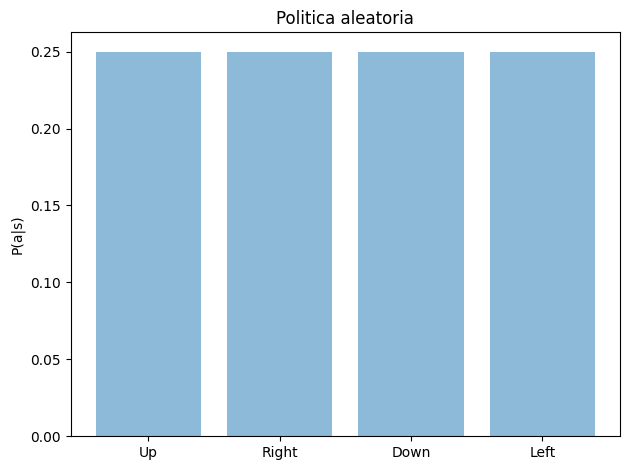

In [12]:
import matplotlib.pyplot as plt
object = ("Up", "Right", "Down", "Left")
y_pos = np.arange(len(object))

plt.bar(y_pos,action_probabilities, alpha = 0.5)
plt.xticks(y_pos,object)
plt.ylabel("P(a|s)")
plt.title("Politica aleatoria")
plt.tight_layout()
plt.show()

##### Usa la política para jugar un episodio (Esta celda ha sido actualizada, lee abajo)

Estimado estudiante, para mantener el contenido del curso actualizado, se ha modificado el código para mostrar nuestra política frente al entorno.  
Esta función funciona de la misma manera que se describe en el video, la única diferencia es que ahora guardamos una captura de pantalla de cada estado en la variable `frames` y luego, usamos la función `display_video` para convertir esas imágenes en un video.

<br>

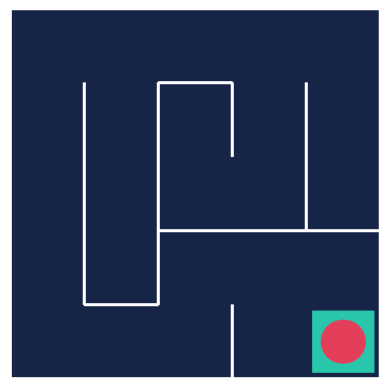

In [13]:
from IPython import display
state = env.reset() #Reinicia el entorno
done = False
img = plt.imshow(env.render(mode='rgb_array'))
while not done:
  action = np.random.choice(range(4),1,p = action_probabilities)
  _,_,done,_ = env.step(action)
  img.set_data(env.render(mode='rgb_array'))
  plt.axis("off")
  display.display(plt.gcf())
  display.clear_output(wait=True)
env.close()

In [14]:
def test_agent(enviroment,policy):
  frames = []
  state = env.reset() #Reinicia el entorno
  done = False
  frames.append(env.render(mode='rgb_array'))
  while not done:
    actions_probs = policy(state)
    action = np.random.choice(range(4),1,p = actions_probs)
    next_state,reward,done,info_extra = env.step(action)
    img = env.render(mode='rgb_array')
    frames.append(img)
    state = next_state
  return display_video(frames)

test_agent(env,random_policy)